In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'ML/KRembedding/'

LIB_PATH = 'lib'
DATA_PATH = '/notebooks/embedding/data/'

%cd drive/My\ Drive/$FOLDERNAME/

# 학습된 단어 임베딩 다운로드
!bash preprocess.sh dump-word-embeddings

Mounted at /content/drive
/content/drive/My Drive/ML/KRembedding


In [2]:
# Mecab 설치
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Installing automake (A dependency for mecab-ko)
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 P

In [3]:
import sys
sys.path.append('/content/drive/MyDrive/'+FOLDERNAME+LIB_PATH)

## 4.7.2 단어 유사도 평가

In [2]:
!wget https://github.com/dongjun-Lee/kor2vec/raw/master/test_dataset/kor_ws353.csv -P $DATA_PATH/raw

--2021-06-08 07:16:53--  https://github.com/dongjun-Lee/kor2vec/raw/master/test_dataset/kor_ws353.csv
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dongjun-Lee/kor2vec/master/test_dataset/kor_ws353.csv [following]
--2021-06-08 07:16:53--  https://raw.githubusercontent.com/dongjun-Lee/kor2vec/master/test_dataset/kor_ws353.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6753 (6.6K) [text/plain]
Saving to: ‘/notebooks/embedding/data//raw/kor_ws353.csv.1’

kor_ws353.csv.1     100%[===================>]   6.59K  --.-KB/s    in 0s      

2021-06-08 07:16:53 (75.1 MB/s) - ‘/notebooks/embedding/da

In [4]:
from models.word_eval import WordEmbeddingEvaluator

def get_model(model_name):
  if model_name == 'word2vec':
    return WordEmbeddingEvaluator(
        vecs_txt_fname=DATA_PATH+'word-embeddings/word2vec/word2vec',
        method='word2vec', dim=100, tokenizer_name='mecab')
  elif model_name == 'fasttext':
    return WordEmbeddingEvaluator(
        vecs_txt_fname=DATA_PATH+'word-embeddings/fasttext/fasttext.vec',
        vecs_bin_fname=DATA_PATH+'word-embeddings/fasttext/fasttext.bin',
        method='fasttext', dim=100, tokenizer_name='mecab')
  elif model_name == 'glove':
    return WordEmbeddingEvaluator(
        vecs_txt_fname=DATA_PATH+'word-embeddings/glove/glove.txt',
        method='glove', dim=100, tokenizer_name='mecab')
  elif model_name == 'swivel':
    return WordEmbeddingEvaluator(
        vecs_txt_fname=DATA_PATH+'word-embeddings/swivel/row_embedding.tsv',
        method='swivel', dim=100, tokenizer_name='mecab')
  else:
    print('model name error!')

In [ ]:
import numpy as np
import scipy.stats as st

model_corr = {}
for model_name in ['word2vec', 'fasttext', 'glove', 'swivel']:
  model = get_model(model_name)

  actual_sim_list, pred_sim_list = [], []
  missed = 0
  with open(DATA_PATH+'raw/kor_ws353.csv', 'r') as pairs:
    for pair in pairs:
      w1, w2, actual_sim = pair.strip().split(",")
      try:
        w1_vec = model.get_sentence_vector(w1)
        w2_vec = model.get_sentence_vector(w2)
        score = np.dot(w1_vec, w2_vec)
        actual_sim_list.append(float(actual_sim))
        pred_sim_list.append(score)
      except KeyError:
        missed += 1
  spearman, _ = st.spearmanr(actual_sim_list, pred_sim_list)
  pearson, _ = st.pearsonr(actual_sim_list, pred_sim_list)
  model_corr[model_name] = {'spearman': spearman, 'pearson': pearson}

In [ ]:
import pandas as pd

mnames = model_corr.keys()
df = pd.DataFrame({
    'spearman': [ model_corr[m]['spearman'] for m in mnames ],
    'pearson': [ model_corr[m]['pearson'] for m in mnames ]
}, index=mnames)

(0.4, 0.6705486450174952)

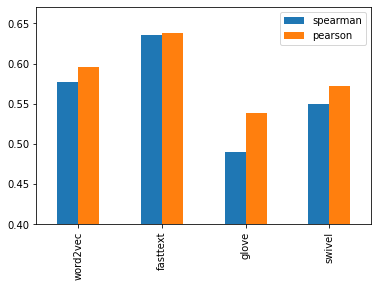

In [ ]:
import matplotlib.pyplot as plt

ax = df.plot.bar()
ax.set_ylim(.4,)

## 4.7.3 단어 유추 평가

In [6]:
!wget https://github.com/dongjun-Lee/kor2vec/raw/master/test_dataset/kor_analogy_semantic.txt -P $DATA_PATH/raw

--2021-06-08 07:36:52--  https://github.com/dongjun-Lee/kor2vec/raw/master/test_dataset/kor_analogy_semantic.txt
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dongjun-Lee/kor2vec/master/test_dataset/kor_analogy_semantic.txt [following]
--2021-06-08 07:36:52--  https://raw.githubusercontent.com/dongjun-Lee/kor2vec/master/test_dataset/kor_analogy_semantic.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14759 (14K) [text/plain]
Saving to: ‘/notebooks/embedding/data//raw/kor_analogy_semantic.txt’

kor_analogy_semanti 100%[===================>]  14.41K  --.-KB/s    in 0s      

2021-06-08 07:36

현재 `model.word_analogy_test()` 의 implementation에 잘못된 부분이 있어 수정합니다.

책 본문에서는 단어 유추 평가 데이터셋(@dongjun_Lee on Github)의 한 sample `갑,을,병,정` 에 대해, 다음과 같은 유추가 올바르게 되는지 확인함으로써 embedding의 성능을 평가할 수 있다고 주장합니다.

```python
nearest_vector(갑 - 을 + 병) == 정   # note: pseudo code
```

그러나, 여기에서 사용하는 데이터셋(표4-7)의 순서를 생각하면, 

| 갑 | 을 | 병 | 정 |
|----|----|----|----|
|대한민국|서울|일본|도쿄|
|대한민국|서울|중국|베이징|

`갑-을 = 병-정`의 등식이 성립하도록 구성되어 있으므로,

```python
nearest_vector(을 - 갑 + 병) == 정
```
와 같은 순서를 사용해야 본래의 관계를 반영할 수 있습니다.

따라서, `get_analogy_vector()` 를 계산할 때 `갑`과 `을`의 순서를 바꾸어 전달합니다.

이렇게 했을 때, 본문에서 보고하는 단어 유추 평가 결과보다 정확도가 크게 향상되는 것을 확인할 수 있습니다.

In [72]:
from tqdm import tqdm

model_analogy_score = {}
for model_name in ['word2vec', 'fasttext', 'glove', 'swivel']:
    model = get_model(model_name)
    correct, total, missed = 0, 0, 0
    with open(DATA_PATH+'raw/kor_analogy_semantic.txt', 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc='evaluating model {}'.format(model_name), mininterval=0.01):
            if line.startswith("#") or len(line) <= 1:
                continue
            words = line.strip().split(" ")

            # swap back and forth
            words = [words[1], words[0], *words[2:]]

            query_vecs = model.get_analogy_vector(words[:-1])
            try:
                word_with_scores = model.most_similar_by_vector(query_vecs, topn=30)    # topn=30: default value from original implementation
                similar_words = [el[0] for el in word_with_scores]
                if words[-1] in similar_words:
                    correct += 1
            except:
                missed += 1
            total += 1
    model_analogy_score[model_name] = {
        'score': correct / (total - missed),
        'correct': correct,
        'total': total,
        'missed': missed
    }

evaluating model word2vec: 423it [03:42,  1.90it/s]
evaluating model fasttext: 423it [03:42,  1.90it/s]
evaluating model glove: 423it [03:37,  1.95it/s]
evaluating model swivel: 423it [01:09,  6.05it/s]


In [73]:
model_analogy_score

{'fasttext': {'correct': 261,
  'missed': 0,
  'score': 0.6214285714285714,
  'total': 420},
 'glove': {'correct': 289,
  'missed': 0,
  'score': 0.6880952380952381,
  'total': 420},
 'swivel': {'correct': 342,
  'missed': 0,
  'score': 0.8142857142857143,
  'total': 420},
 'word2vec': {'correct': 256,
  'missed': 0,
  'score': 0.6095238095238096,
  'total': 420}}

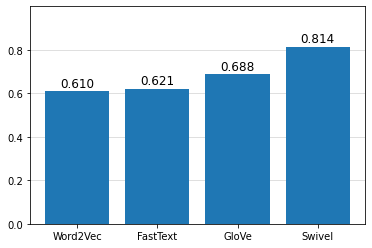

In [76]:
import matplotlib.pyplot as plt

X = ['Word2Vec', 'FastText', 'GloVe', 'Swivel']
Y = [ model_analogy_score[name.lower()]['score'] for name in X ]

fig, ax = plt.subplots()
ax.bar(X, Y, zorder=3)

for x,y in zip(X,Y) :
  ax.text(x, y+0.02, '{:.3f}'.format(y), ha='center', size='large')

ax.set_ylim(0,1)
ax.grid(axis='y', alpha=0.5)
ax.set_yticks(np.arange(0, 1, 0.2))

plt.show()

## 4.7.4 단어 임베딩 시각화

In [77]:
from models.visualize_utils import visualize_words

model = get_model('swivel')

with open(DATA_PATH+'raw/kor_analogy_semantic.txt', 'r') as f:
    words = [ word.strip().split() for word in f.readlines() if '#' not in word ]
    words = [ word for li in words for word in li ]     # flatten lists in list
    words = list(set(words))    # reduce multiple elements
    vecs = np.array([model.get_sentence_vector(word) for word in words])

visualize_words(words, vecs, palette="Viridis256", use_notebook=True)

In [78]:
from models.visualize_utils import visualize_between_words

visualize_between_words(words, vecs, palette="Viridis256", use_notebook=True)